*Data Engineering Project on COVID-19 DataLake by AWS*

Performing data modeling, data wrangling and extract-load-transform using python on the COVID-19 Data Lake available on registry of open data AWS using various AWS tools such as boto3, Glue, S3, Athena and Redshift.

Tools and Usages:

- Amazon S3 - Storing the data
- Crawler - Used to extract all the schema and information straight from S3
- Amazon Athena - Running adhoc sql queries on the available data in S3
- AWS Glue - Data transformation
- Amazon Redshift - Storing the tranfromed dimensional model in datawarehouse
- boto3 - AWS python sdk for create, configure, and manage AWS services.

Data Set: https://registry.opendata.aws/aws-covid19-lake/

How to get the data?

- Simply download and upload to S3 bucket
- Using AWS CLI copy command: aws s3 cp s3://mybucket/test.txt s3://mybucket/test2.txt
- Running in code by boto3

STEPS:

- Running Crawlers on the data uploaded in S3
- Analysing data using AWS Athena query editor
- Building the ER-Data Model
- ETL jobs in python
- Saving result in S3
- Building the Dimensional Model
- Building Dimensional schema in Redshift
- Storing the dimensional model into Redshift

Project inspired: COVID 19 - Build End to End Data Engineering Project | PART 1 - https://www.youtube.com/watch?v=gFWu-SSzRzc&t=464s

In [ ]:
%pip install --user boto3
%pip install --user awscli
%pip install --user redshift-connector
%pip install --user wget

In [ ]:
import boto3
import pandas as pd
import os
import configparser
import pprint
from io import StringIO
from botocore.client import ClientError
import time
import wget

Read the Configuration File to get the main variables and info to proceed in AWS.

In [ ]:
config = configparser.ConfigParser()
config.read_file(open('Resources/cluster.config'))

AWS_KEY                 = os.environ.get('AWS_KEY')
AWS_SECRET              = os.environ.get('AWS_SECRET')
AWS_REGION              = config.get("AWS","AWS_REGION")
SCHEMA_NAME             = config.get("PROJECT","SCHEMA_NAME")

S3_ACL                  = config.get("S3","S3_ACL")
S3_LOCATION             = config.get("S3","S3_LOCATION")
S3_BUCKET_NAME          = config.get("S3","S3_BUCKET_NAME")
S3_STAGING_DIR          = config.get("S3","S3_STAGING_DIR")
S3_OUTPUT_DIRECTORY     = config.get("S3","S3_OUTPUT_DIRECTORY")

CRAWLER_ROLE            = config.get("CRAWLER","CRAWLER_ROLE")
CRAWLER_OUTPUT          = config.get("CRAWLER","CRAWLER_OUTPUT")

DWH_CLUSTER_TYPE        = config.get("DWH","DWH_CLUSTER_TYPE")
DWH_NUM_NODES           = config.get("DWH","DWH_NUM_NODES")
DWH_NODE_TYPE           = config.get("DWH","DWH_NODE_TYPE")
DWH_CLUSTER_IDENTIFIER  = config.get("DWH","DWH_CLUSTER_IDENTIFIER")
DWH_DB                  = config.get("DWH","DWH_DB")
DWH_DB_USER             = config.get("DWH","DWH_DB_USER")
DWH_DB_PASSWORD         = config.get("DWH","DWH_DB_PASSWORD")
DWH_PORT                = config.get("DWH","DWH_PORT")
DWH_IAM_ROLE_NAME       = config.get("DWH","DWH_IAM_ROLE_NAME")

GLUE_JOB_NAME           = config.get("GLUE","GLUE_JOB_NAME")
GLUE_IAM_ROLE_NAME      = config.get("GLUE","GLUE_IAM_ROLE_NAME")
GLUE_TYPE               = config.get("GLUE","GLUE_TYPE")
GLUE_LIBRARY_PATH       = config.get("GLUE","GLUE_LIBRARY_PATH")
GLUE_PYTHON_SCRIPT      = config.get("GLUE","GLUE_PYTHON_SCRIPT")
GLUE_S3_LIBRARY_PATH    = config.get("GLUE","GLUE_S3_LIBRARY_PATH")
GLUE_S3_PYTHON_SCRIPT   = config.get("GLUE","GLUE_S3_PYTHON_SCRIPT")

1st Step - Create S3 Bucket using Python

Create the S3 Client service and check if the bucket already exists in S3, if yes do nothing. If not, create the S3 bucket.

In [ ]:
s3_client = boto3.client('s3', 
                aws_access_key_id=AWS_KEY,
                aws_secret_access_key=AWS_SECRET,
                region_name=AWS_REGION)

try:
    s3_client.head_bucket(Bucket=S3_BUCKET_NAME)
    bucket_exists = 'Yes'
    print("The bucket exists")
except ClientError:
    bucket_exists = 'No'
    print("The bucket does no exist or you have no access")

In [ ]:
try:
    if bucket_exists == 'No':
        create_bucket = s3_client.create_bucket(Bucket=S3_BUCKET_NAME, 
                    ACL=S3_ACL, 
                    CreateBucketConfiguration = {'LocationConstraint': S3_LOCATION})
        print(pprint.pprint(create_bucket))
except ClientError as e:
    print(e)

2st Step - Copy Dataset into the created Bucket
Dataset chosen: https://registry.opendata.aws/aws-covid19-lake/

In [ ]:
InfosToCopy = pd.read_csv('Resources/dataInfosCopy.csv', delimiter=";", header=None)
InfosToCopy.head(10)

Copy the specific data from the open data set into the S3 Bucket with the folders path

In [ ]:
s3_resource = boto3.resource('s3', 
                aws_access_key_id=AWS_KEY,
                aws_secret_access_key=AWS_SECRET)

In [ ]:
for position in range(len(InfosToCopy)):
    s3_resource.Bucket(S3_BUCKET_NAME).copy({"Bucket": InfosToCopy.iat[position,0], "Key": InfosToCopy.iat[position,1]}, InfosToCopy.iat[position,2])
    print(position, "-", InfosToCopy.iat[position,2], "- Dowloaded")

3rd Step - Set-up the Data Crawler to understand the Data, how many columns and rows.
Understand the data to build the data model.

In [ ]:
glue_client = boto3.client('glue', 
                aws_access_key_id=AWS_KEY,
                aws_secret_access_key=AWS_SECRET,
                region_name=AWS_REGION)

for position in range(len(InfosToCopy)):
    CrawlerName = InfosToCopy.iat[position,4] + "_crawler"
    CrawlerPath = "s3://" + S3_BUCKET_NAME + "/" + InfosToCopy.iat[position,3]
    
    CrawlerCreation = glue_client.create_crawler(
        Name=CrawlerName,
        Role=CRAWLER_ROLE,
        DatabaseName=SCHEMA_NAME,
        Description='Crawler for generated tables in the bucket',
        Targets={
            'S3Targets': [
                {
                    'Path': CrawlerPath,
                    'Exclusions': [
                    ]
                },
            ]
        },
        SchemaChangePolicy={
            'UpdateBehavior': 'UPDATE_IN_DATABASE',
            'DeleteBehavior': 'DELETE_FROM_DATABASE'
        }
    )
    CrawlerStart = glue_client.start_crawler(
        Name=CrawlerName
    ) 

4th Step - Build the relational data model

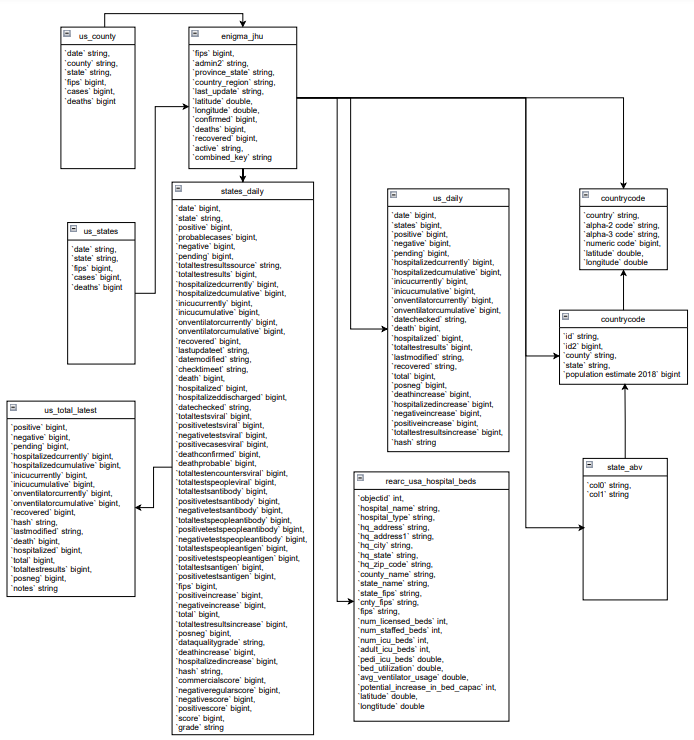

5th Step - Connect athena and query data

In [ ]:
athena_client = boto3.client('athena', 
                aws_access_key_id=AWS_KEY,
                aws_secret_access_key=AWS_SECRET,
                region_name=AWS_REGION
                )

In [ ]:
Dict={}
def download_and_load_query_results(
    client: boto3.client, query_response: Dict
) -> pd.DataFrame:
    while True:
        try:
            client.get_query_results(
                QueryExecutionId=query_response["QueryExecutionId"]
            )
            break
        except Exception as err:
            if "not yet finished" in str(err):
                time.sleep(0.001)
            else:
                raise err
    temp_file_location: str = "Resources/athena_query_results.csv"
    s3_client.download_file(
        S3_BUCKET_NAME,
        f"{S3_OUTPUT_DIRECTORY}/{query_response['QueryExecutionId']}.csv",
        temp_file_location,
        )
    return pd.read_csv(temp_file_location)

Using the results generated by the crawlers, use Athena to create the DataFrames from each file in S3.

In [ ]:
response = athena_client.start_query_execution(
    QueryString = "SELECT * FROM enigma_jhu",
    QueryExecutionContext = {"Database": SCHEMA_NAME},
    ResultConfiguration = {
        "OutputLocation": S3_STAGING_DIR,
        "EncryptionConfiguration": {"EncryptionOption": "SSE_S3"},
    },
)
enigma_jhu = download_and_load_query_results(athena_client, response)
enigma_jhu.head()

In [ ]:
response = athena_client.start_query_execution(
    QueryString = "SELECT * FROM us_county",
    QueryExecutionContext = {"Database": SCHEMA_NAME},
    ResultConfiguration = {
        "OutputLocation": S3_STAGING_DIR,
        "EncryptionConfiguration": {"EncryptionOption": "SSE_S3"},
    },
)
us_county = download_and_load_query_results(athena_client, response)
us_county.head()

In [ ]:
response = athena_client.start_query_execution(
    QueryString = "SELECT * FROM us_states",
    QueryExecutionContext = {"Database": SCHEMA_NAME},
    ResultConfiguration = {
        "OutputLocation": S3_STAGING_DIR,
        "EncryptionConfiguration": {"EncryptionOption": "SSE_S3"},
    },
)
us_states = download_and_load_query_results(athena_client, response)
us_states.head()

In [ ]:
response = athena_client.start_query_execution(
    QueryString = "SELECT * FROM states_daily",
    QueryExecutionContext = {"Database": SCHEMA_NAME},
    ResultConfiguration = {
        "OutputLocation": S3_STAGING_DIR,
        "EncryptionConfiguration": {"EncryptionOption": "SSE_S3"},
    },
)
states_daily = download_and_load_query_results(athena_client, response)
states_daily.head()

In [ ]:
response = athena_client.start_query_execution(
    QueryString = "SELECT * FROM us_total_latest",
    QueryExecutionContext = {"Database": SCHEMA_NAME},
    ResultConfiguration = {
        "OutputLocation": S3_STAGING_DIR,
        "EncryptionConfiguration": {"EncryptionOption": "SSE_S3"},
    },
)
us_total_latest = download_and_load_query_results(athena_client, response)
us_total_latest.head()

In [ ]:
response = athena_client.start_query_execution(
    QueryString = "SELECT * FROM us_daily",
    QueryExecutionContext = {"Database": SCHEMA_NAME},
    ResultConfiguration = {
        "OutputLocation": S3_STAGING_DIR,
        "EncryptionConfiguration": {"EncryptionOption": "SSE_S3"},
    },
)
us_daily = download_and_load_query_results(athena_client, response)
us_daily.head()

In [ ]:
response = athena_client.start_query_execution(
    QueryString = "SELECT * FROM rearc_usa_hospital_beds",
    QueryExecutionContext = {"Database": SCHEMA_NAME},
    ResultConfiguration = {
        "OutputLocation": S3_STAGING_DIR,
        "EncryptionConfiguration": {"EncryptionOption": "SSE_S3"},
    },
)
rearc_usa_hospital_beds = download_and_load_query_results(athena_client, response)
rearc_usa_hospital_beds.head()

In [ ]:
response = athena_client.start_query_execution(
    QueryString = "SELECT * FROM countrycode",
    QueryExecutionContext = {"Database": SCHEMA_NAME},
    ResultConfiguration = {
        "OutputLocation": S3_STAGING_DIR,
        "EncryptionConfiguration": {"EncryptionOption": "SSE_S3"},
    },
)
countrycode = download_and_load_query_results(athena_client, response)
countrycode.head()

In [ ]:
response = athena_client.start_query_execution(
    QueryString = "SELECT * FROM CountyPopulation",
    QueryExecutionContext = {"Database": SCHEMA_NAME},
    ResultConfiguration = {
        "OutputLocation": S3_STAGING_DIR,
        "EncryptionConfiguration": {"EncryptionOption": "SSE_S3"},
    },
)
CountyPopulation = download_and_load_query_results(athena_client, response)
CountyPopulation.head()

In [ ]:
response = athena_client.start_query_execution(
    QueryString = "SELECT * FROM state_abv",
    QueryExecutionContext = {"Database": SCHEMA_NAME},
    ResultConfiguration = {
        "OutputLocation": S3_STAGING_DIR,
        "EncryptionConfiguration": {"EncryptionOption": "SSE_S3"},
    },
)
state_abv = download_and_load_query_results(athena_client, response)
state_abv.head()

Fix the headers from state_abv DataFrame 

In [ ]:
new_header = state_abv.iloc[0] #grab the first row for the header
state_abv = state_abv[1:] #take the data less the header row
state_abv.columns = new_header #set the header row as the df header
state_abv.head()

6th Step - ETL job in Python -> Start building the dimensional model by transforming the the dataframes into fact and dimensional tables.

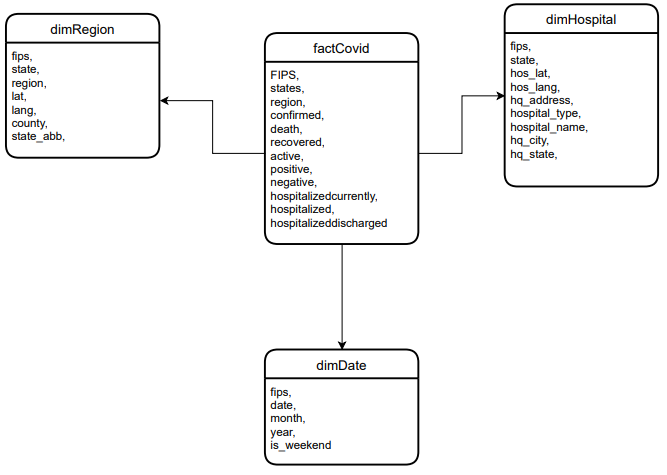

In [ ]:
factCovid_1 = enigma_jhu[['fips', 'province_state', 'country_region', 'confirmed', 'deaths', 'recovered', 'active']]
factCovid_2 = states_daily[['fips', 'date', 'positive', 'negative', 'hospitalizedcurrently', 'hospitalized', 'hospitalizeddischarged']]
factCovid = pd.merge(factCovid_1, factCovid_2, on='fips', how='inner')
factCovid.head()

In [ ]:
factCovid.shape

In [ ]:
dimRegion_1 = enigma_jhu[['fips', 'province_state', 'country_region', 'latitude', 'longitude']]
dimRegion_2 = us_county[['fips', 'county', 'state']]
dimRegion = pd.merge(dimRegion_1, dimRegion_2, on='fips', how='inner')
dimRegion.head()

In [ ]:
dimHospital = rearc_usa_hospital_beds[['fips', 'state_name', 'latitude', 'longtitude', 'hq_address', 'hospital_name', 'hospital_type', 'hq_city', 'hq_state']]
dimHospital.head()

In [ ]:
dimDate = states_daily[['fips', 'date']]
dimDate.head()

In [ ]:
dimDate['date'] = pd.to_datetime(dimDate['date'], format='%Y%m%d')
dimDate.head()

In [ ]:
dimDate['year'] = dimDate['date'].dt.year
dimDate['month'] = dimDate['date'].dt.month
dimDate['day_of_week'] = dimDate['date'].dt.dayofweek
dimDate.head()

7th Step - Save results into S3

In [ ]:
csv_buffer = StringIO()
factCovid.to_csv(csv_buffer)
s3_resource.Object(S3_BUCKET_NAME, 'output/factCovid.csv').put(Body=csv_buffer.getvalue())
# Time to process and upload - 2.1s - 2MB

In [ ]:
csv_buffer = StringIO()
dimDate.to_csv(csv_buffer)
s3_resource.Object(S3_BUCKET_NAME, 'output/dimDate.csv').put(Body=csv_buffer.getvalue())
# Time to process and upload - 1.4s - 600KB

In [ ]:
csv_buffer = StringIO()
dimHospital.to_csv(csv_buffer)
s3_resource.Object(S3_BUCKET_NAME, 'output/dimHospital.csv').put(Body=csv_buffer.getvalue())
# Time to process and upload - 0.9s - 1MB

In [ ]:
csv_buffer = StringIO()
dimRegion.to_csv(csv_buffer)
s3_resource.Object(S3_BUCKET_NAME, 'output/dimRegion.csv').put(Body=csv_buffer.getvalue())
# Time to process and upload - 28m 13.2s - 2.4GB

8th Step - Create clusters and build tables on redshift

In [ ]:
#Obtain the table schema of every table from the ETL job
dimDatesql = pd.io.sql.get_schema(dimDate.reset_index(),'dimDate')
dimRegionsql = pd.io.sql.get_schema(dimRegion.reset_index(),'dimRegion')
dimHospitalsql = pd.io.sql.get_schema(dimHospital.reset_index(),'dimHospital')
factCovidsql = pd.io.sql.get_schema(factCovid.reset_index(),'factCovid')

In [ ]:
import redshift_connector

redshift_client = boto3.client('redshift',
                    region_name=AWS_REGION,
                    aws_access_key_id=AWS_KEY,
                    aws_secret_access_key=AWS_SECRET
                    )

In [ ]:
iam = boto3.client('iam',
                    region_name=AWS_REGION,
                    aws_access_key_id=AWS_KEY,
                    aws_secret_access_key=AWS_SECRET
                    )

roleArn = iam.get_role(RoleName=DWH_IAM_ROLE_NAME)['Role']['Arn']

In [ ]:
#Create Redshift Cluster using the Free Trial dc2.large with 1 node
try:
    response = redshift_client.create_cluster(
        ClusterType=DWH_CLUSTER_TYPE,
        NodeType=DWH_NODE_TYPE,

        #Identifiers & Credentials
        DBName=DWH_DB,
        ClusterIdentifier=DWH_CLUSTER_IDENTIFIER,
        MasterUsername=DWH_DB_USER,
        MasterUserPassword=DWH_DB_PASSWORD,

        #Roles (for s3 access)
        IamRoles=[roleArn]
    )
except Exception as e:
    print(e)

In [ ]:
conn = redshift_connector.connect(
    host=redshift_client.describe_clusters(ClusterIdentifier=DWH_CLUSTER_IDENTIFIER)['Clusters'][0]['Endpoint']['Address'],
    database=DWH_DB,
    user=DWH_DB_USER,
    password=DWH_DB_PASSWORD
)
conn.autocommit = True
cursor = redshift_connector.Cursor = conn.cursor()

In [ ]:
#Option to create the tables in redshift
cursor.execute(dimDatesql)
cursor.execute(dimRegionsql)
cursor.execute(dimHospitalsql)
cursor.execute(factCovidsql)

9th Step - Copy data to redshift

In [ ]:
cursor.execute("""
copy dimDate from 's3://hfelipini-covid19-project/output/dimDate.csv'
credentials 'aws_iam_role=arn:aws:iam::732284161643:role/redshift-s3-access'
delimiter ','
region 'sa-east-1'
IGNOREHEADER 1
""")

In [ ]:
cursor.execute("""
copy dimRegion from 's3://hfelipini-covid19-project/output/dimRegion.csv'
credentials 'aws_iam_role=arn:aws:iam::732284161643:role/redshift-s3-access'
delimiter ','
region 'sa-east-1'
IGNOREHEADER 1
""")

In [ ]:
cursor.execute("""
copy dimHospital from 's3://hfelipini-covid19-project/output/dimHospital.csv'
credentials 'aws_iam_role=arn:aws:iam::732284161643:role/redshift-s3-access'
delimiter ','
region 'sa-east-1'
IGNOREHEADER 1
""")


In [ ]:
cursor.execute("""
copy factCovid from 's3://hfelipini-covid19-project/output/factCovid.csv'
credentials 'aws_iam_role=arn:aws:iam::732284161643:role/redshift-s3-access'
delimiter ','
region 'sa-east-1'
IGNOREHEADER 1
""")

9th - Download the Redshift Connector Package for Python and upload it into S3
Redshift Connector: https://files.pythonhosted.org/packages/24/3c/471f5f7d43f1ed1be87494010f466849fe2376acf8bab49d4b676f870cf1/redshift_connector-2.0.909-py3-none-any.whl

In [ ]:
# Download the Redshift_Connector Package

URL = 'https://files.pythonhosted.org/packages/24/3c/471f5f7d43f1ed1be87494010f466849fe2376acf8bab49d4b676f870cf1/redshift_connector-2.0.909-py3-none-any.whl'
response = wget.download(URL, 'Resources/redshift_connector-2.0.909-py3-none-any.whl')

In [ ]:
# Upload the Redshift_Connector Package into the "package" folder in S3
file_name_package = 'Resources/redshift_connector-2.0.909-py3-none-any.whl'
s3_client.upload_file(file_name_package, S3_BUCKET_NAME, GLUE_S3_LIBRARY_PATH)

# Upload the Python Script 
file_name_python_script = 'Resources/s3_glue_redshift.py'
s3_client.upload_file(file_name_python_script, S3_BUCKET_NAME, GLUE_S3_PYTHON_SCRIPT)

10th - Configure Glue Job

In [ ]:
glue = boto3.client('glue',
                    region_name=AWS_REGION,
                    aws_access_key_id=AWS_KEY,
                    aws_secret_access_key=AWS_SECRET
                    )

job = glue.create_job(Name=GLUE_JOB_NAME,
                      Role=GLUE_IAM_ROLE_NAME,
                      Command={'Name': 'pythonshell',
                               'ScriptLocation': GLUE_PYTHON_SCRIPT,
                               'PythonVersion': '3'
                        },
                      DefaultArguments={'--extra-py-files': GLUE_LIBRARY_PATH}
                      )
job

In [ ]:
# Start the job run
run_job = glue.start_job_run(JobName=GLUE_JOB_NAME,
                           Arguments={'--extra-py-files': GLUE_LIBRARY_PATH})
run_job

Now you can Query in the RedShift query editor with the Dimensionals and Fact tables!!
Don't forget, at the end, to delete the Crawlers, Jobs & clusters to don't receive a charge from AWS at the end of the month!!

Best regards and good practice!